In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import Descriptors
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from pycaret.regression import *
from pycaret.regression import save_model                                                                                                                                                                           vb  

In [17]:
descriptor_names = [desc[0] for desc in Descriptors.descList]

# カノニカル SMILES に変換する関数
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Chem.MolToSmiles(mol, canonical=True)
    return None

# すべての記述子を取得
def compute_all_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return [Descriptors.__dict__[desc](mol) for desc in descriptor_names]

In [18]:
#--------------------------
#前処理
#--------------------------

# データの読み込み
df = pd.read_csv("data/iupac_high-confidence_v2_2.csv")
print(df.shape)
# 不要な記号を削除（>, <, ~）
df["pka_value"] = df["pka_value"].astype(str).str.replace('>', '').str.replace('<', '').str.replace('~', '').str.strip()

# 数値変換（変換できない値は NaN にする）
df["pka_value"] = pd.to_numeric(df["pka_value"], errors='coerce')

# NaN を削除（文字列だったデータのみ削除）
df = df.dropna(subset=["pka_value"])

# pKa を float に変換
df["pka_value"] = df["pka_value"].astype(float)

# 新しいカラム "canonical_SMILES" を追加
df["canonical_SMILES"] = df["SMILES"].apply(canonicalize_smiles)

# データ確認
print(df.shape)

# カノニカル SMILES の重複数を確認
duplicates = df["canonical_SMILES"].duplicated().sum()
print(f"🔍 重複している分子の数: {duplicates}")

# 2. 重複を削除して最初のデータだけ残す
df_unique = df.drop_duplicates(subset="canonical_SMILES", keep="first")

# データ確認
print(f"✅ 重複除去後のデータ数: {df_unique.shape[0]}")
print(df.shape,df_unique.shape)

(24222, 21)
(24199, 22)
🔍 重複している分子の数: 13512
✅ 重複除去後のデータ数: 10687
(24199, 22) (10687, 22)


In [19]:
# すべての記述子を DataFrame に変換
X = pd.DataFrame([compute_all_descriptors(smiles) for smiles in df_unique["canonical_SMILES"]], columns=descriptor_names)
X["pKa"] = df_unique["pka_value"].values  # pKa を追加
display(X.head())


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pKa
0,6.277778,6.277778,0.166667,0.166667,0.297364,6.250000,58.084,52.036,58.053098,24,...,0,0,0,0,0,0,0,0,0,12.400
1,4.500000,4.500000,1.500000,1.500000,0.384658,3.000000,31.058,26.018,31.042199,14,...,0,0,0,0,0,0,0,0,0,10.657
2,9.465278,9.465278,0.055556,-0.467593,0.394253,7.400000,74.083,68.035,74.048013,30,...,0,0,0,0,0,0,0,0,0,7.950
3,9.819444,9.819444,0.045139,-0.351852,0.196057,7.666667,89.098,82.042,89.058912,36,...,0,0,0,0,0,0,0,0,0,7.690
4,7.500000,7.500000,0.125000,0.125000,0.379084,5.000000,56.068,52.036,56.037448,22,...,0,0,0,0,0,0,0,0,0,5.340


In [21]:
# 記述子だけをスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(columns=["pKa"]))

# スケーリング後のデータフレーム
X_scaled_df = pd.DataFrame(X_scaled, columns=descriptor_names)
X_scaled_df["pKa"] = X["pKa"]
# X_scaled_df["canonical_SMILES"] = df_unique["canonical_SMILES"].values

display(X_scaled_df.head())
print(X_scaled_df.shape)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pKa
0,-0.838742,-0.838742,-0.566061,0.477775,-1.945845,-1.044861,-1.771145,-1.772523,-1.771375,-1.712793,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,12.400
1,-1.443548,-1.443548,2.920097,1.431139,-1.329124,-1.554346,-2.123637,-2.125234,-2.124226,-2.080298,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,10.657
2,0.245657,0.245657,-0.856574,0.024266,-1.261336,-0.864581,-1.562474,-1.555633,-1.562428,-1.492291,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,7.950
3,0.366145,0.366145,-0.883810,0.107023,-2.661560,-0.822777,-1.366638,-1.365748,-1.366337,-1.271788,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,7.690
4,-0.422938,-0.422938,-0.675004,0.447983,-1.368508,-1.240817,-1.797439,-1.772523,-1.797706,-1.786294,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,5.340


(10687, 218)


In [22]:
# NaN を含む行を削除
X_scaled_df_cleaned = X_scaled_df.dropna()

# 対応する pKa も削除
y_cleaned = X_scaled_df_cleaned["pKa"]
X_cleaned = X_scaled_df_cleaned.drop(columns=["pKa"])
# X_cleaned = X_scaled_df_cleaned.drop(columns=["pKa","canonical_SMILES"])

print(f"✅ NaN を削除したデータ数: {X_cleaned.shape}")

✅ NaN を削除したデータ数: (10569, 217)


In [23]:
X_scaled_df_cleaned

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pKa
0,-0.838742,-0.838742,-0.566061,0.477775,-1.945845,-1.044861,-1.771145,-1.772523,-1.771375,-1.712793,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,12.400
1,-1.443548,-1.443548,2.920097,1.431139,-1.329124,-1.554346,-2.123637,-2.125234,-2.124226,-2.080298,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,10.657
2,0.245657,0.245657,-0.856574,0.024266,-1.261336,-0.864581,-1.562474,-1.555633,-1.562428,-1.492291,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,7.950
3,0.366145,0.366145,-0.883810,0.107023,-2.661560,-0.822777,-1.366638,-1.365748,-1.366337,-1.271788,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,7.690
4,-0.422938,-0.422938,-0.675004,0.447983,-1.368508,-1.240817,-1.797439,-1.772523,-1.797706,-1.786294,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,5.340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10682,1.247646,1.247646,-0.713979,-0.685601,-1.209901,0.295478,3.711606,3.707547,3.716165,4.020275,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,2.700
10683,1.090201,1.090201,-0.910137,-3.094006,-3.285667,-0.044051,5.226256,5.336516,5.230528,5.049287,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,5.790
10684,1.487726,1.487726,-0.430313,-0.297807,-1.057100,0.503192,2.902684,2.948752,2.905959,2.991263,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,3.680
10685,1.374980,1.374980,-0.577191,-0.210864,-1.340856,0.428267,3.242290,3.274405,3.245809,3.358767,...,-0.102118,-0.084035,-0.053735,-0.038722,-0.078226,-0.016757,-0.07567,-0.122112,-0.104882,4.110


In [24]:
# PyCaret のセットアップ（数値データのみを使用）
regression_setup = setup(
    data=X_scaled_df_cleaned, 
    target="pKa", 
    normalize=True,  # 特徴量の正規化
    train_size=0.8,  # 訓練データの割合
    session_id=42
)


,Description,Value
0,Session id,42
1,Target,pKa
2,Target type,Regression
3,Original data shape,"(10569, 218)"
4,Transformed data shape,"(10569, 218)"
5,Transformed train set shape,"(8455, 218)"
6,Transformed test set shape,"(2114, 218)"
7,Numeric features,217
8,Preprocess,True
9,Imputation type,simple


In [9]:
# 相関行列を計算
corr_matrix = X_scaled_df_cleaned.drop(columns=["canonical_SMILES"]).corr()

# pKa と相関の高い特徴量を選択
top_features = corr_matrix["pKa"].abs().sort_values(ascending=False).index[1:101]  # 上位20個

# 選択した特徴量のみを使用
X_selected = X_scaled_df_cleaned[top_features]
y = X_scaled_df_cleaned["pKa"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

model_svm = SVR(kernel="rbf", C=10, gamma="scale")
model_svm.fit(X_train, y_train)

y_pred_svm = model_svm.predict(X_test)

print(f"SVM - MSE: {mean_squared_error(y_test, y_pred_svm):.3f}, R²: {r2_score(y_test, y_pred_svm):.3f}")


SVM - MSE: 7.264, R²: 0.585


In [11]:
data = X_scaled_df_cleaned[top_features]
data["pKa"] = X_scaled_df_cleaned["pKa"].values


C:\Users\redoc\AppData\Local\Temp\ipykernel_22444\2217018403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["pKa"] = X_scaled_df_cleaned["pKa"].values


In [12]:
from pycaret.regression import *

# PyCaret のセットアップ（数値データのみを使用）
regression_setup = setup(
    data=data, 
    target="pKa", 
    normalize=True,  # 特徴量の正規化
    train_size=0.8,  # 訓練データの割合
    session_id=42
)


,Description,Value
0,Session id,42
1,Target,pKa
2,Target type,Regression
3,Original data shape,"(10569, 101)"
4,Transformed data shape,"(10569, 101)"
5,Transformed train set shape,"(8455, 101)"
6,Transformed test set shape,"(2114, 101)"
7,Numeric features,100
8,Preprocess,True
9,Imputation type,simple


In [25]:

# 指定したモデルだけを比較
selected_models = ["et", "rf", "lightgbm", "knn", "gbr", "ridge", "br", "huber", "dt"]
best_model = compare_models(include=selected_models)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.2828,4.9042,2.2083,0.7083,0.3715,0.7988,11.7340
rf,Random Forest Regressor,1.4512,5.5935,2.3610,0.6671,0.3900,0.8914,24.6960
lightgbm,Light Gradient Boosting Machine,1.6253,5.9609,2.4388,0.6452,0.4204,0.9764,1.1030
knn,K Neighbors Regressor,1.7056,7.5261,2.7410,0.5521,0.4539,0.9142,0.2900
gbr,Gradient Boosting Regressor,2.0417,8.2426,2.8695,0.5094,0.4760,1.2505,6.9640
dt,Decision Tree Regressor,1.9620,11.5767,3.3998,0.3104,0.5091,1.1238,0.6570
huber,Huber Regressor,2.3043,15.1023,3.6994,0.0774,0.5100,1.2711,0.9720
br,Bayesian Ridge,2.3880,22.2968,4.0722,-0.3913,0.5247,1.2860,0.1720
ridge,Ridge Regression,2.3840,32.5700,4.4486,-1.0598,0.5269,1.2586,0.0980


In [26]:
model = create_model(best_model)
tuned_model = tune_model(model)
save_model(tuned_model, "models/pKa_best_model")


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1844,3.7942,1.9479,0.7533,0.3616,1.5273
1,1.2155,3.9622,1.9905,0.7696,0.3838,0.6593
2,1.2750,4.8206,2.1956,0.7062,0.3503,0.6790
3,1.4010,6.3633,2.5226,0.6349,0.3818,0.7786
4,1.2059,4.4721,2.1147,0.7349,0.3536,0.6636
5,1.3100,4.9030,2.2143,0.7197,0.3851,0.6352
6,1.3799,5.2499,2.2913,0.6807,0.4086,0.5784
7,1.1573,4.5050,2.1225,0.7384,0.3379,0.6724
8,1.3434,5.6211,2.3709,0.6623,0.3903,0.8700


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3400,9.5062,3.0832,0.3820,0.4985,2.3698
1,2.4245,10.7079,3.2723,0.3772,0.5059,1.3682
2,2.4655,10.8089,3.2877,0.3412,0.4989,1.4542
3,2.5122,11.9677,3.4594,0.3133,0.5219,1.4946
4,2.3696,10.5314,3.2452,0.3756,0.4828,1.4943
5,2.5111,11.1818,3.3439,0.3608,0.5186,1.3042
6,2.4763,10.9836,3.3141,0.3320,0.4899,1.1143
7,2.4135,11.0624,3.3260,0.3576,0.5133,1.4572
8,2.4416,10.9263,3.3055,0.3435,0.5145,1.6038


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['MaxAbsEStateIndex',
                                              'MaxEStateIndex',
                                              'MinAbsEStateIndex',
                                              'MinEStateIndex', 'qed', 'SPS',
                                              'MolWt', 'HeavyAtomMolWt',
                                              'ExactMolWt',
                                              'NumValenceElectrons',
                                              'NumRadicalElectrons',
                                              'MaxPartialCharge',
                                              'MinPartialCharge',
                                              'MaxAbsPartialCharge',
                                              'MinAbsPartialCharge',
                                              'FpDen...
                                              'B

In [27]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [29]:
# チューニング後のモデルのスコアを取得
tuned_results = pull()
print(tuned_results)


                   Model     MAE     MSE    RMSE      R2   RMSLE    MAPE
0  Extra Trees Regressor  1.2164  4.3697  2.0904  0.7502  0.3746  0.8145


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.2164,4.3697,2.0904,0.7502,0.3746,0.8145


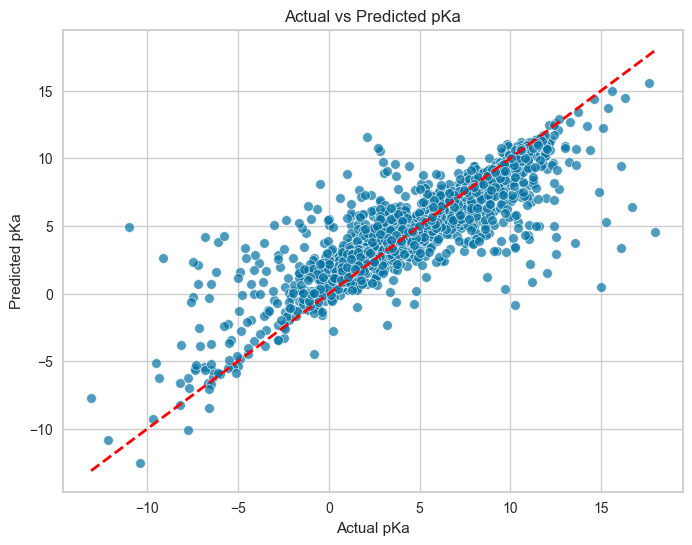

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# テストデータで予測
predictions = predict_model(tuned_model)

# プロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions["pKa"], y=predictions["prediction_label"], alpha=0.7)
plt.plot([min(predictions["pKa"]), max(predictions["pKa"])], 
         [min(predictions["pKa"]), max(predictions["pKa"])], 
         color="red", linestyle="--", linewidth=2)  # 理想の直線
plt.xlabel("Actual pKa")
plt.ylabel("Predicted pKa")
plt.title("Actual vs Predicted pKa")
plt.show()


In [ ]:


save_model(best_model, "pKa_best_model")


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['FractionCSP3',
                                              'MinAbsPartialCharge',
                                              'MaxPartialCharge', 'SMR_VSA5',
                                              'BCUT2D_LOGPLOW', 'VSA_EState8',
                                              'fr_nitro', 'BCUT2D_CHGLO',
                                              'fr_NH1', 'SMR_VSA6',
                                              'fr_nitro_arom', 'SPS', 'Phi',
                                              'VSA_EState2', 'SMR_VSA4',
                                              'SlogP_VSA5', 'PEOE_VSA7',
                                              'Kappa2', 'PEOE_VSA14',
                                              'NHOHCount',...
                                              'fr_COO2', 'fr_COO',
                                              'NumSaturatedHeterocycl

In [ ]:
model = create_model(best_model)
tuned_model = tune_model(model)
save_model(tuned_model, "pKa_best_model")



,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:16:37
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# テストデータで予測
predictions = predict_model(best_model)

# NaN の除去
predictions = predictions.dropna(subset=["pKa", "Label"])

# R²（決定係数）を計算
r2 = r2_score(predictions["pKa"], predictions["Label"])

# プロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions["pKa"], y=predictions["Label"], alpha=0.7)

# 理想の直線 (y = x)
min_val = min(predictions["pKa"].min(), predictions["Label"].min())
max_val = max(predictions["pKa"].max(), predictions["Label"].max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=2)

# R² をプロットに表示
plt.text(min_val + 1, max_val - 1, f"R² = {r2:.3f}", fontsize=12, color="blue")

plt.xlabel("Actual pKa")
plt.ylabel("Predicted pKa")
plt.title("Actual vs Predicted pKa")

plt.show()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.2164,4.3697,2.0904,0.7502,0.3746,0.8145


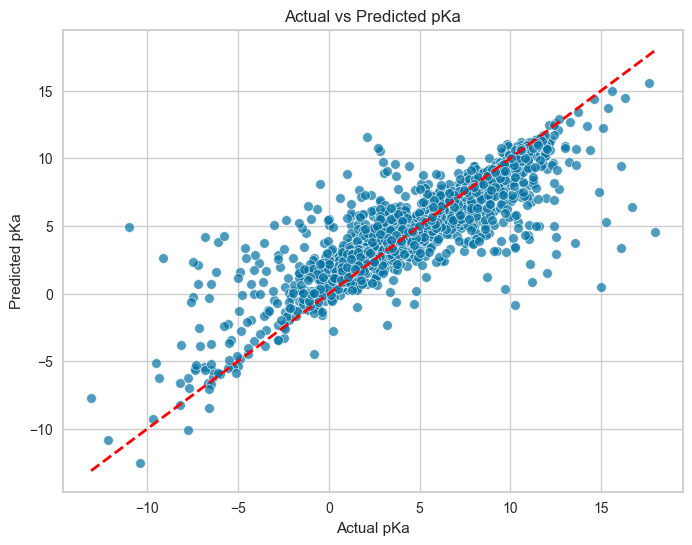

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# テストデータで予測
predictions = predict_model(best_model)

# プロット
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions["pKa"], y=predictions["prediction_label"], alpha=0.7)
plt.plot([min(predictions["pKa"]), max(predictions["pKa"])], 
         [min(predictions["pKa"]), max(predictions["pKa"])], 
         color="red", linestyle="--", linewidth=2)  # 理想の直線
plt.xlabel("Actual pKa")
plt.ylabel("Predicted pKa")
plt.title("Actual vs Predicted pKa")
plt.show()
